In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, CSV
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
d, Nobs = 5, 20
X = randn(d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) + 0. for j in 1:Nobs];
σ02 = 1;

In [3]:
# prior = SS_prior(d, σ02)
prior = gaussian_prior_nh(d, σ02)
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior);

In [5]:
ξ0 = zeros(d)
epsilon = 3e-3
L = 100
T = 10_000

xi_samples, hyper_samples, acc = GibbsHMC(my_model, ξ0, epsilon, L, T);

10 percent steps in 0.3 min; HMC acceptance = 100 percent 
20 percent steps in 0.5 min; HMC acceptance = 100 percent 
30 percent steps in 0.8 min; HMC acceptance = 100 percent 
40 percent steps in 1.1 min; HMC acceptance = 100 percent 
50 percent steps in 1.3 min; HMC acceptance = 100 percent 
60 percent steps in 1.6 min; HMC acceptance = 100 percent 
70 percent steps in 1.8 min; HMC acceptance = 100 percent 
80 percent steps in 2.1 min; HMC acceptance = 100 percent 
90 percent steps in 2.4 min; HMC acceptance = 100 percent 
100 percent steps in 2.6 min; HMC acceptance = 100 percent 


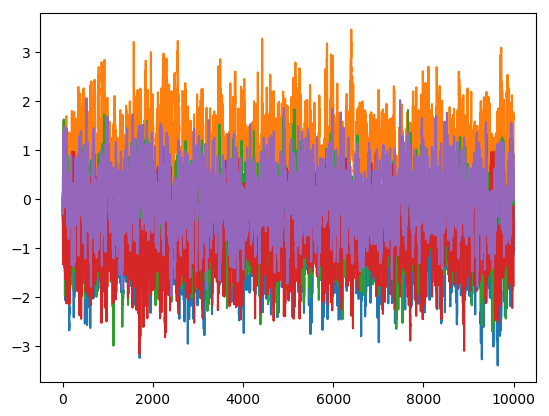

In [6]:
for i in 1:size(xi_samples,1)
    plot(xi_samples[i,:]) 
end

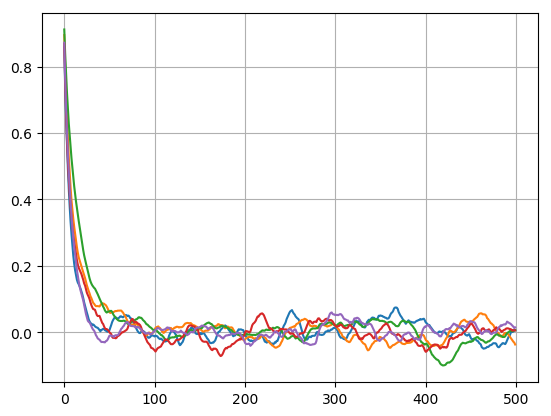

In [8]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 500))
end
grid(true)

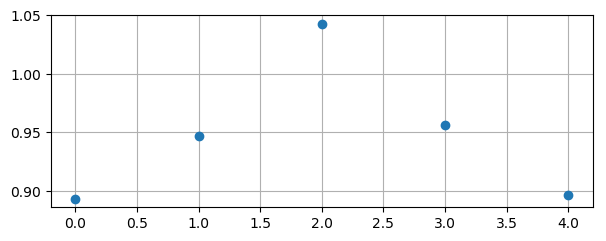

In [9]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples, hyper_samples, k) for k in 1:d], "o")
grid(true)

In [15]:
function HMC_test(model::model, current_q, epsilon, L) 
    
    q = copy(current_q)
    p = randn(length(current_q))
    current_p = copy(p)
    total_energy = zeros(L)
    
    p -= epsilon*gradient(model,q)/2    
    @showprogress for i in 1:L 
        q += epsilon*p 
        if i!=L 
            p -= epsilon*gradient(model,q)
        end
        total_energy[i] = -log_posterior(model, q) + sum(p.^2)/2
    end 
    return total_energy
end

HMC_test (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

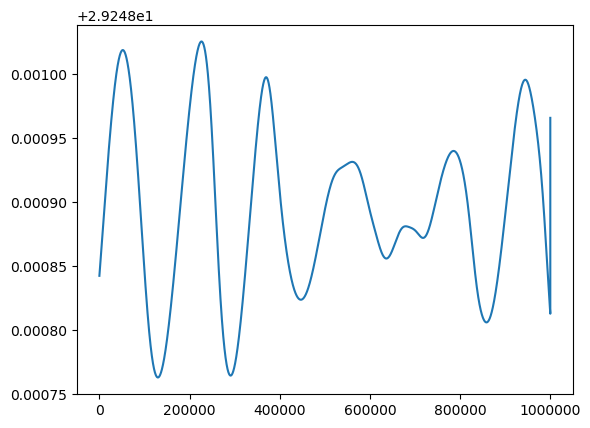

Progress: 100%|█████████████████████████████████████████| Time: 0:04:08


In [16]:
total_energy = HMC_test(my_model, randn(d), 1e-5, 10^6)
plot(total_energy);